# Variational Autoencoder

In [ ]:
%tensorflow_version 1.x

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_week5()

TensorFlow 1.x selected.
--2021-08-06 01:44:27--  https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1232 (1.2K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.20K  --.-KB/s    in 0s      

2021-08-06 01:44:27 (72.3 MB/s) - ‘setup_google_colab.py’ saved [1232/1232]

https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week5/w5_grader.py w5_grader.py
https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/week5/test_data.npz test_data.npz


In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from w5_grader import VAEGrader

Using TensorFlow backend.


### Variational Autoencoder

### Loss Function

In [ ]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    reconstruction_loss=-K.mean(K.sum(x*K.log(x_decoded_mean+1e-6)+(1-x)*K.log(1-x_decoded_mean+1e-6),axis=1))
    Kl=K.mean(0.5*K.sum(K.square(t_mean)+K.exp(t_log_var)-t_log_var-1,axis=1))
    return reconstruction_loss+ Kl

## Encoder / decoder

In [ ]:
batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 100 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 30

x = Input(batch_shape=(batch_size, original_dim))
def create_encoder(input_dim):
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)


def sampling(args):
    t_mean, t_log_var = args
    return t_mean+K.exp(0.5*t_log_var)*K.random_normal(t_mean.shape)

t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder
decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Training the model

In [ ]:
loss = vlb_binomial(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
vae.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss=lambda x, y: loss)

#### Load and preparing the data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#### Train the model

In [ ]:
hist = vae.fit(x=x_train, y=x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test, x_test),
               verbose=2)


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
 - 2s - loss: 164.9993 - val_loss: 141.1204
Epoch 2/30
 - 2s - loss: 136.0277 - val_loss: 128.5908
Epoch 3/30
 - 2s - loss: 125.8133 - val_loss: 121.2084
Epoch 4/30
 - 2s - loss: 119.2267 - val_loss: 115.6778
Epoch 5/30
 - 2s - loss: 115.3557 - val_loss: 112.7666
Epoch 6/30
 - 2s - loss: 112.9880 - val_loss: 110.9659
Epoch 7/30
 - 2s - loss: 111.4742 - val_loss: 109.7732
Epoch 8/30
 - 2s - loss: 110.3786 - val_loss: 110.1039
Epoch 9/30
 - 2s - loss: 109.7235 - val_loss: 110.1031
Epoch 10/30
 - 2s - loss: 109.1494 - val_loss: 109.2405
Epoch 11/30
 - 2s - loss: 108.6439 - val_loss: 107.5201
Epoch 12/30
 - 2s - loss: 108.3479 - val_loss: 108.7084
Epoch 13/30
 - 2s - loss: 108.0035 - val_loss: 108.0131
Epoch 14/30
 - 2s - loss: 107.7367 - val_loss: 106.9239
Epoch 15/30
 - 2s - loss: 107.4860 - val_loss: 107.1913
Epoch 16/30
 - 2s - loss: 107.2688 - val_loss: 107.4786
Epoch 17/30
 - 2s - loss: 107.0788 - val_loss: 106.5893
Epoch 

## New data

In [ ]:
n_samples = 10 
sampled_im_mean = decoder(tf.random_normal((n_samples, latent_dim)))

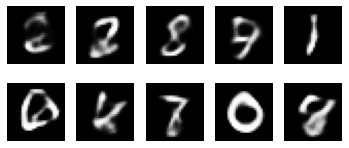

In [ ]:
sampled_im_mean_np = sess.run(sampled_im_mean)
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()